In [1]:
import warnings
warnings.filterwarnings('ignore')

# Domain libraries

Different domain libraries contain data loading functions for different data sources.

| Problem Space         | Pre-build datasets and functions |
| :-------------------: | :------------------------------: |
| Vision                | `torchvision.datasets`           |
| Text                  | `torchtext.datasets`             |
| Audio                 | `torchaudio.datasets`            |
| Recommendation system | `torchrec.datasets`              |
| TorchData (in beta)   | `Torchdata`                      |

Depending on what you are working on, you may want to look into each of the PyTorch domain libraries for existing and customizable data loading functions.

In [2]:
import torch

torch.__version__

'2.1.1'

# Setup device agnostic code

**Note**: Sometimes, depending on your data/hardware, you might find that your model trains faster on CPU than GPU. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 1. Custom dataset

When starting **machine learning** projects, it is important to try things on a small scale and then increase the scale when necessary. This is especially true when working with large datasets and you need to speed up the experiments. In this notebook, we will learn how to create a custom dataset class for a small dataset using a simplified version of [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset from `torchvision.datasets`, with only three food categories and only 100 images per category.

In [4]:
import pathlib
import torchvision.datasets as datasets

# setup data directory
data_dir = pathlib.Path("data")

# get training and testing data
train_data = datasets.Food101(root=data_dir, split="train", download=True)
test_data = datasets.Food101(root=data_dir, split="test", download=True)

In [5]:
train_data, test_data

(Dataset Food101
     Number of datapoints: 75750
     Root location: data
     split=train,
 Dataset Food101
     Number of datapoints: 25250
     Root location: data
     split=test)

In [6]:
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

'churros'

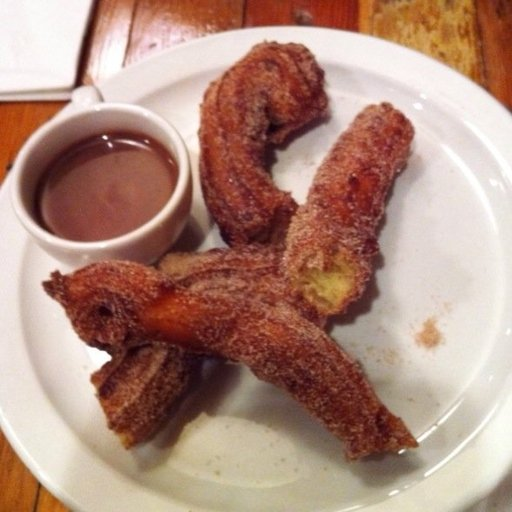

In [7]:
# View first sample (PIL Image format)
image = train_data[0]
display(class_names[image[1]])
image[0]

## 1.1. Becoming one with the data

Preparing and visualizing the data is an important step in the machine learning pipeline. It is important to understand the data format and the range of values in the dataset. This helps in choosing the appropriate preprocessing steps and estimating the range of values that the model needs to predict.

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">“If I had 8 hours to build a machine learning model, I’d spend the first 6 hours preparing my dataset.”<br><br>- Abraham Lossfunction</p>&mdash; Daniel Bourke (@mrdbourke) <a href="https://twitter.com/mrdbourke/status/1456087631641473033?ref_src=twsrc%5Etfw">November 4, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [8]:
import random

def get_random_subset(image_path=data_dir / "food-101" / "images",
                      data_splits=["train", "test"], 
                      target_classes=["pizza", "steak", "sushi"],
                      amount=0.1,
                      seed=42):
    random.seed(seed)
    label_splits = {}
    
    # get labels
    for data_split in data_splits:
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes] 
        
        # get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        sampled_images = random.sample(labels, k=number_to_sample)
        
        # apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits
        
label_splits = get_random_subset()
label_splits.keys(), len(label_splits["train"]), len(label_splits["test"])

(dict_keys(['train', 'test']), 225, 75)

In [9]:
label_splits["train"][:5]

[PosixPath('data/food-101/images/pizza/3269634.jpg'),
 PosixPath('data/food-101/images/pizza/1524655.jpg'),
 PosixPath('data/food-101/images/steak/2825100.jpg'),
 PosixPath('data/food-101/images/steak/225990.jpg'),
 PosixPath('data/food-101/images/steak/1839481.jpg')]

In [10]:
label_splits["test"][:5]

[PosixPath('data/food-101/images/sushi/684266.jpg'),
 PosixPath('data/food-101/images/sushi/988559.jpg'),
 PosixPath('data/food-101/images/sushi/1987407.jpg'),
 PosixPath('data/food-101/images/sushi/3837522.jpg'),
 PosixPath('data/food-101/images/sushi/887831.jpg')]

In [11]:
label_splits["train"][0].parent.stem

'pizza'

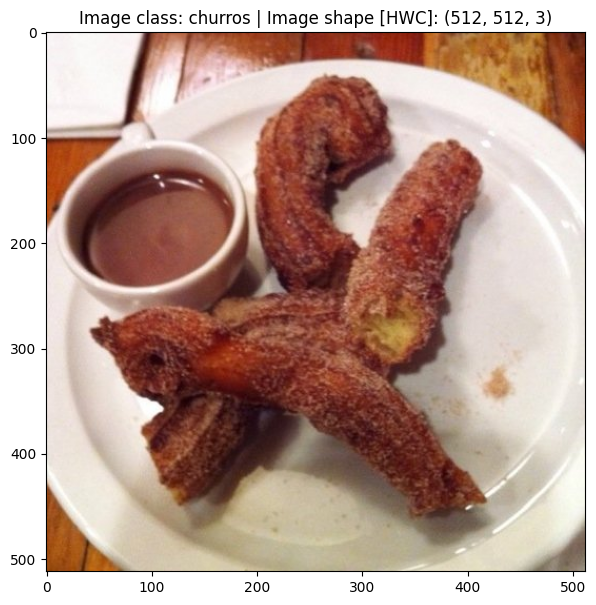

In [12]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(image[0])

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {class_names[image[1]]} | Image shape [HWC]: {img_as_array.shape}");

## 1.2. Move training and testing images to dedicated folder

In [13]:
target_dir_name = f"data/food-101/pizza-steak-sushi"
target_dir = pathlib.Path(target_dir_name)
target_dir.mkdir(parents=True, exist_ok=True)

In [14]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(image_path, dest_dir)

In [15]:
import os

for dirpath, dirnames, filenames in os.walk(target_dir):
  if len(dirnames) == 0:
    print(f"There are {len(filenames)} images in '{dirpath}'.")

There are 19 images in 'data/food-101/pizza-steak-sushi/test/steak'.
There are 31 images in 'data/food-101/pizza-steak-sushi/test/sushi'.
There are 25 images in 'data/food-101/pizza-steak-sushi/test/pizza'.
There are 75 images in 'data/food-101/pizza-steak-sushi/train/steak'.
There are 72 images in 'data/food-101/pizza-steak-sushi/train/sushi'.
There are 78 images in 'data/food-101/pizza-steak-sushi/train/pizza'.


# 2. Transforming data with `torchvision.transforms`

The data is in the height, width, color channels format (HWC). However, PyTorch expects the color channels to be first (CHW). In order to make the data compatible with PyTorch, we need to turn data into tensors using the `torchvision.transforms.ToTensor` class, then turn it into a `torch.utils.data.Dataset` subclass and subsequently a `torch.utils.data.DataLoader`.

Another option is to use the `ImageFolder` base class from PyTorch that implements the `transform` method to transform a PIL image into a tensor. We can use this method to transform the data into tensors.

In [16]:
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),        # resize the image to 64x64 (to speed up training)
    transforms.RandomHorizontalFlip(p=0.5),  # randomly flip image horizontally (data augmentation)
    transforms.ToTensor(),                   # convert image to tensors
])

data_transforms(image[0]).shape, data_transforms(image[0]).type()

(torch.Size([3, 64, 64]), 'torch.FloatTensor')

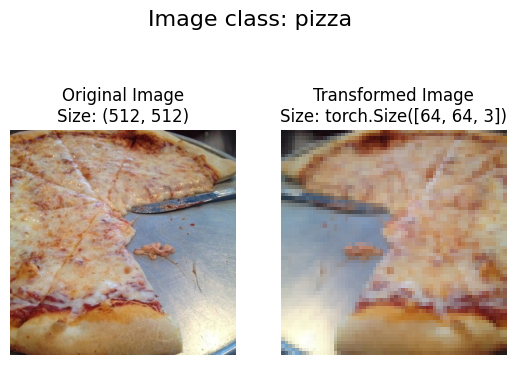

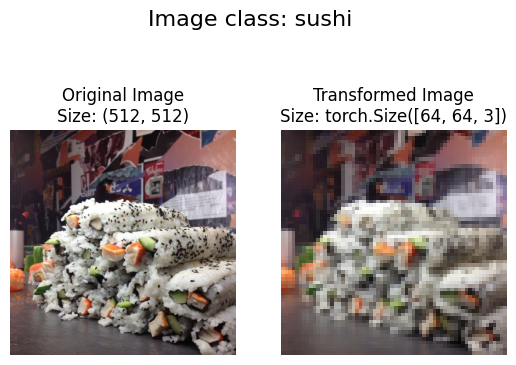

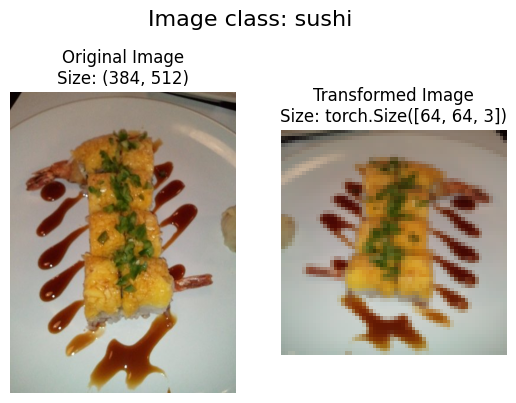

In [17]:
from torchvision.transforms import Compose
from PIL import Image

def plot_transformed_images(image_paths: list, transform: Compose, n: int = 3, seed: int = None):
    """Plots n number of images after applying the transform"""
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)

    for image_paths in random_image_paths:
        with Image.open(image_paths) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original Image\nSize: {img.size}")
            ax[0].set_axis_off()

            transformed_img = transform(img).permute(1, 2, 0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed Image\nSize: {transformed_img.shape}")
            ax[1].set_axis_off()

            fig.suptitle(f"Image class: {image_paths.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=label_splits["train"], transform=data_transforms)

## 2.1. Loading image data using `ImageFolder`

In [18]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=target_dir / "train", transform=data_transforms)
test_data = ImageFolder(root=target_dir / "test", transform=data_transforms)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/food-101/pizza-steak-sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/food-101/pizza-steak-sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

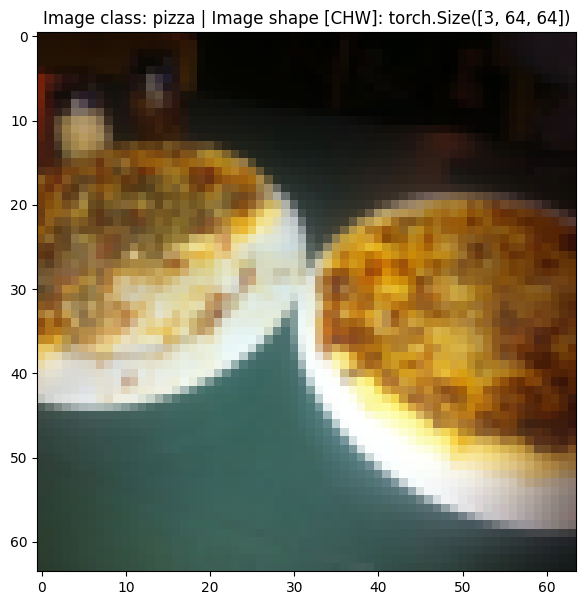

In [19]:
plt.figure(figsize=(10, 7))
plt.imshow(np.array(train_data[0][0].permute(1, 2, 0)))
plt.title(f"Image class: {train_data.classes[train_data[0][1]]} | Image shape [CHW]: {train_data[0][0].shape}");

## 2.2. Turning images into `Dataloader` batches

In [20]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=os.cpu_count())

len(train_dataloader), len(test_dataloader)

(8, 3)

In [25]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# 3. Food Vision Mini

Building Food Vision Mini to classify images

# 4. Data augmentation

Comparing models with and without data augmentation

# 5. Making predictions

Making predictions on custom data

# References

1. [Ground Truth Notebook](https://www.learnpytorch.io/04_pytorch_custom_datasets/)